# Comparing  old and new feature generation functions to ensure identical results

In [1]:
import spock
import random
import numpy as np
import rebound
import pandas as pd
from spock import simsetup
from spock import FeatureKlassifier
from spock import FeatureClassifier

We can load initial conditions from our system dataset as REBOUND simulations

we will look at a subset of the resonant systems to ensure compatibility

In [2]:
#specify the data path
datapath = '../cleanData/csvs/resonant/clean_initial_conditions.csv'
initial = pd.read_csv(datapath)
#drop junk column
initial = initial.drop('Unnamed: 0', axis = 1)
initial.head()

,p0m,p0x,p0y,p0z,p0vx,p0vy,p0vz,p1m,p1x,p1y,...,p2vy,p2vz,p3m,p3x,p3y,p3z,p3vx,p3vy,p3vz,runstring
0,0.999996,0.000007,-0.000018,1.269113e-07,0.000059,0.000031,-7.653712e-08,3.984920e-06,-0.982960,-0.183683,...,-0.437075,-0.002895,2.531702e-07,-1.288724,0.962201,-0.018973,-3.077432,-3.851732,-0.164377,0000000.bin
1,1.000000,-0.000020,0.000003,-3.832419e-07,-0.000015,-0.000092,2.664138e-06,2.065557e-07,0.845257,-0.535312,...,5.610770,-0.157725,6.830431e-07,-1.327142,0.550229,-0.009861,-1.680953,-4.761961,-0.052477,0000001.bin
2,1.000000,0.000057,-0.000215,-1.197840e-06,0.000394,0.000225,1.018178e-06,1.797281e-07,0.899352,-0.407481,...,-5.756639,0.019097,9.648477e-05,-0.208863,2.258035,0.009349,-4.143923,-0.430091,-0.016918,0000002.bin
3,0.999953,0.000071,0.000045,2.256372e-06,-0.000199,0.000297,-1.334874e-06,4.704418e-05,-0.819392,-0.685703,...,-0.179467,0.045955,1.615758e-05,-2.003066,-0.132781,-0.004192,0.293880,-4.423427,0.115038,0000003.bin
4,0.999996,-0.000063,0.000013,1.256863e-06,-0.000045,-0.000265,-3.323176e-06,3.514145e-06,0.865534,0.497927,...,0.668516,0.002231,4.655600e-05,1.292557,-0.324317,-0.026652,1.326032,5.277415,0.076018,0000004.bin


We can establish a function that, given a list of initial conditions, will return a rebound simulation

In [3]:
def get_sim(row, dataset):
    '''Given a row number, and a data sheet containing initial conditions, returns a corresponding simulation
    
        Arguments:
            row: what row the simulation you would like to create is on
                format of row is in order: 
                [index, 'p0m', 'p0x', 'p0y', 'p0z', 'p0vx', 'p0vy', 'p0vz', 'p1m', 'p1x', 'p1y',
                'p1z', 'p1vx', 'p1vy', 'p1vz', 'p2m', 'p2x', 'p2y', 'p2z', 'p2vx',
                'p2vy', 'p2vz', 'p3m', 'p3x', 'p3y', 'p3z', 'p3vx', 'p3vy', 'p3vz']

            dataset: what dataset contains your initial conditions

        return: returns a rebound simulation with the specified initial conditions'''
    try:
        data = dataset.loc[row]
        sim = rebound.Simulation()
        sim.G=4*np.pi**2
        sim.add(m=data['p0m'], x=data['p0x'], y=data['p0y'], z=data['p0z'], vx=data['p0vx'], vy=data['p0vy'], vz=data['p0vz'])
        sim.add(m=data['p1m'], x=data['p1x'], y=data['p1y'], z=data['p1z'], vx=data['p1vx'], vy=data['p1vy'], vz=data['p1vz'])
        sim.add(m=data['p2m'], x=data['p2x'], y=data['p2y'], z=data['p2z'], vx=data['p2vx'], vy=data['p2vy'], vz=data['p2vz'])
        sim.add(m=data['p3m'], x=data['p3x'], y=data['p3y'], z=data['p3z'], vx=data['p3vx'], vy=data['p3vy'], vz=data['p3vz'])
        return sim
    except:
        print("Error reading initial condition {0}".format(row))
        return None

We can now randomly sample 1000 simulations to compare

In [4]:
#generates the indexes of the systems
systemNum = range(initial.shape[0])
#creates the set of simulations
simSet = list(map((lambda i: get_sim(i,initial)),systemNum))

We can note the column names and import the different feature generators

In [5]:
col = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear', 'EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'MEGNO', 'MEGNOstd']

In [6]:
new = FeatureKlassifier()
old = FeatureClassifier()

In [7]:
def getList(features):
    '''Helper function which isolates the data list from the generate_features return'''
    return list(features[0][0].values())

We need to use a external python file in order to make multiprocessing work with jupyter notebook

we can then create the list of all generated features using both methods

In [8]:
from multiprocessing import Pool
import compairHelper
if __name__ == "__main__":
    with Pool() as pool:
        new = pool.map(compairHelper.getNew,simSet)
        old = pool.map(compairHelper.getOld,simSet)
        pool.close()
        pool.join()
newMeth = pd.DataFrame(np.array(list(map(getList,new))), columns = col)
oldMeth = pd.DataFrame(np.array(list(map(getList,old))), columns = col)



combining both data sheets we are left with a datasheet that has two rows for each system, one of which is generated using the new method and one with the old method. We can then create a column which tells you if a identical duplicate of each row, which, since each system has a unique index, tells us if the old and new methods created identical datasets.

In [9]:
allData = pd.concat([newMeth,oldMeth])
allData['dup'] = pd.concat([newMeth,oldMeth]).duplicated(keep=False)

We can then count how many of the datasets have identical duplicates present, which includes having the same index. Note, every system has a unique index

In [10]:
allData['dup'].value_counts()

dup
True    204994
Name: count, dtype: int64

This tells us that every simulation, has a set with identical features and index present, telling us that both feature generation methods generate identical results.

As a additional example we can generate features using both methods for the following example simulation.

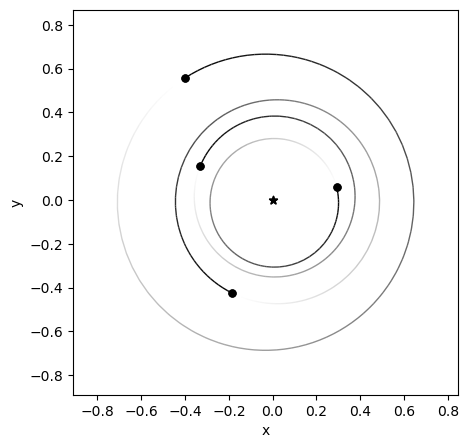

In [11]:
import rebound
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=3.e-5, P=1., e=0.05, pomega = 2.1, l=0.3)
sim.add(m=3.e-5, P=1.4, e=0.05, pomega = 4.2, l=2.8)
sim.add(m=3.e-5, P=2, e=0.05, pomega = 2.8, l=4.2)
sim.add(m=3.e-5, P=3.5, e=0.05, pomega = 0.3, l=2.1)
sim.move_to_com()
fig = rebound.OrbitPlot(sim)

In [13]:
new = FeatureKlassifier()
new.generate_features(sim)

([OrderedDict([('EMcrossnear', 0.25147746328412046),
               ('EMfracstdnear', 0.05074719901234224),
               ('EPstdnear', 0.01253710198425132),
               ('MMRstrengthnear', 0.6098627261371655),
               ('EMcrossfar', 0.2684469716587564),
               ('EMfracstdfar', 0.08025177611798755),
               ('EPstdfar', 0.013481773489721986),
               ('MMRstrengthfar', 0.015537017617854676),
               ('MEGNO', 6.850878520625518),
               ('MEGNOstd', 1.8517061396916448)]),
  OrderedDict([('EMcrossnear', 0.2684469716587564),
               ('EMfracstdnear', 0.08025177611798755),
               ('EPstdnear', 0.013481773489721986),
               ('MMRstrengthnear', 0.015537017617854676),
               ('EMcrossfar', 0.4522109539032094),
               ('EMfracstdfar', 0.055607916757028066),
               ('EPstdfar', 0.008676373013226053),
               ('MMRstrengthfar', nan),
               ('MEGNO', 6.850878520625518),
               ('

In [14]:
old = FeatureClassifier()
old.generate_features(sim)

([OrderedDict([('EMcrossnear', 0.25147746328412046),
               ('EMfracstdnear', 0.05074719901234224),
               ('EPstdnear', 0.01253710198425132),
               ('MMRstrengthnear', 0.6098627261371655),
               ('EMcrossfar', 0.2684469716587564),
               ('EMfracstdfar', 0.08025177611798755),
               ('EPstdfar', 0.013481773489721986),
               ('MMRstrengthfar', 0.015537017617854676),
               ('MEGNO', 6.850878520625518),
               ('MEGNOstd', 1.8517061396916448)]),
  OrderedDict([('EMcrossnear', 0.2684469716587564),
               ('EMfracstdnear', 0.08025177611798755),
               ('EPstdnear', 0.013481773489721986),
               ('MMRstrengthnear', 0.015537017617854676),
               ('EMcrossfar', 0.4522109539032094),
               ('EMfracstdfar', 0.055607916757028066),
               ('EPstdfar', 0.008676373013226053),
               ('MMRstrengthfar', nan),
               ('MEGNO', 6.850878520625518),
               ('

As you can see the generated features are identical. We can therefore conclude that these two methods yield identical results and are interchangeable. The advantage of the new method is it will be easier to upkeep and make alterations to the model in the future.